# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
#  Classification goal is to predict if a client will subscribe (yes/no) to a term deposit (y)
# bank-additional-full has all examples 41188 and 20 inputs ordered by date May 2008 to November 2010)
#   bank-additional.csv has 10% of the full set (for training SVM model if it is too slow)
# bank.csv

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import time
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# class balance is heavily weighted to no case (11%)
print(df[['y']].value_counts())
(df['y'] == 'yes').mean()

y  
no     36548
yes     4640
Name: count, dtype: int64


0.11265417111780131

In [7]:
# Value counts look ok for non-numeric columns
# rare values (default == yes 3, education == illiterate 18, marital == unknown 80)
df.select_dtypes('object').melt().value_counts(dropna=False).sort_index()

variable     value              
contact      cellular               26144
             telephone              15044
day_of_week  fri                     7827
             mon                     8514
             thu                     8623
             tue                     8090
             wed                     8134
default      no                     32588
             unknown                 8597
             yes                        3
education    basic.4y                4176
             basic.6y                2292
             basic.9y                6045
             high.school             9515
             illiterate                18
             professional.course     5243
             university.degree      12168
             unknown                 1731
housing      no                     18622
             unknown                  990
             yes                    21576
job          admin.                 10422
             blue-collar             9254
 

In [8]:
# Remove rare values - their predictive value will be very limited
# Also removing marital == unknown which has n = 80. Even if this has predictive value,
# it won't offer actionable insight for the business as it's really just missing data
df = df.query('default != "yes" & education != "illiterate" & marital != "unknown"')

In [9]:
# These columns need to be OneHotEncoded in the pipeline
categoricalCols = df.select_dtypes('object').drop(columns='y').columns.to_list()
categoricalCols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
# The business objective is to predict if a client will subscribe to a term deposit. This will likely be used by the bank's
# phone center to improve revenue. I think the insights should have two goals, ranked by importance:
#   1) Create a model that most accurately can maximize sales (the yes case). Interpretability is nice but is not required. This
#      will help the phone center prioritize their calling time.
#   2) If the model is interpretable, provide the business group with insights to help them find more marketing leads of
#      a certain profile (likely purchasers). This will make their acquisition costs more efficient.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [11]:
X = df.drop(columns='y')
y = df['y']

In [12]:
# This pipeline should cover the feature engineering, but needs to add an estimator
# in the model creation phase

columnTransformer = ColumnTransformer([
  ('ohe', OneHotEncoder(drop = 'if_binary'), categoricalCols)
], remainder='passthrough')

pipeline = Pipeline([
   ('ct', columnTransformer),
   ('scale', StandardScaler())
 ])

In [13]:
# Apply transformations to X
X = pd.DataFrame(
  pipeline.fit_transform(X),
  columns=pipeline.get_feature_names_out())
X.head()

,ohe__job_admin.,ohe__job_blue-collar,ohe__job_entrepreneur,ohe__job_housemaid,ohe__job_management,ohe__job_retired,ohe__job_self-employed,ohe__job_services,ohe__job_student,ohe__job_technician,...,remainder__age,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__emp.var.rate,remainder__cons.price.idx,remainder__cons.conf.idx,remainder__euribor3m,remainder__nr.employed
0,-0.582418,-0.538343,-0.191333,6.156959,-0.276648,-0.208517,-0.18872,-0.326727,-0.147425,-0.442549,...,1.533757,0.010871,-0.565958,0.19526,-0.34917,0.647788,0.72232,0.886596,0.71219,0.331457
1,-0.582418,-0.538343,-0.191333,-0.162418,-0.276648,-0.208517,-0.18872,3.060662,-0.147425,-0.442549,...,1.629735,-0.421219,-0.565958,0.19526,-0.34917,0.647788,0.72232,0.886596,0.71219,0.331457
2,-0.582418,-0.538343,-0.191333,-0.162418,-0.276648,-0.208517,-0.18872,3.060662,-0.147425,-0.442549,...,-0.289824,-0.124157,-0.565958,0.19526,-0.34917,0.647788,0.72232,0.886596,0.71219,0.331457
3,1.716979,-0.538343,-0.191333,-0.162418,-0.276648,-0.208517,-0.18872,-0.326727,-0.147425,-0.442549,...,-0.001890,-0.413503,-0.565958,0.19526,-0.34917,0.647788,0.72232,0.886596,0.71219,0.331457
4,-0.582418,-0.538343,-0.191333,-0.162418,-0.276648,-0.208517,-0.18872,3.060662,-0.147425,-0.442549,...,1.533757,0.188336,-0.565958,0.19526,-0.34917,0.647788,0.72232,0.886596,0.71219,0.331457


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, stratify=y, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [15]:
# This scores highly due to the class imbalance. This may
# be hard to beat!
baseline = DummyClassifier().fit(xTrain, yTrain)
baseline.score(xTest, yTest)

0.8874610591900312

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [16]:
t0 = time.time()
log = LogisticRegression().fit(xTrain, yTrain)
logTime = time.time() - t0

### Problem 9: Score the Model

What is the accuracy of your model?

In [17]:
# Better than baseline, great!
logTrainScore = log.score(xTrain, yTrain)
logTestScore = log.score(xTest, yTest)
logTestScore

0.9110202492211839

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [18]:
t0 = time.time()
knn = KNeighborsClassifier().fit(xTrain, yTrain)
knnTime = time.time() - t0
knnTrainScore = knn.score(xTrain, yTrain)
knnTestScore = knn.score(xTest, yTest)

In [19]:
t0 = time.time()
dt = DecisionTreeClassifier().fit(xTrain, yTrain)
dtTime = time.time() - t0
dtTrainScore = dt.score(xTrain, yTrain)
dtTestScore = dt.score(xTest, yTest)

In [20]:
t0 = time.time()
svm = SVC().fit(xTrain, yTrain)
svmTime = time.time() - t0
svmTrainScore = svm.score(xTrain, yTrain)
svmTestScore = svm.score(xTest, yTest)

In [21]:
# All of the accuracy scores are quite high, DT has 100% accuracy as expected given
# we are not limiting the depth and there is no overlapping records. Logistic regression
# and SVM scored the best on the test set.

# All models were quick to train except for SVM, which was significantly slower.

pd.DataFrame({
  'Model': ['Logistic','KNN','DT','SVM'],
  'Train Time': [logTime, knnTime, dtTime, svmTime],
  'Train Accuracy': [logTrainScore, knnTrainScore, dtTrainScore, svmTrainScore],
  'Test Accuracy': [logTestScore, knnTestScore, dtTestScore, svmTestScore]
})

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic,0.343169,0.911050,0.911020
1,KNN,0.041494,0.917994,0.899046
2,DT,0.171218,1.000000,0.894081
3,SVM,11.772243,0.929645,0.908781


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [22]:
# I already did some feature selection above, I dropped sparse features
# and a category of "unknown" given it is really a missing value.

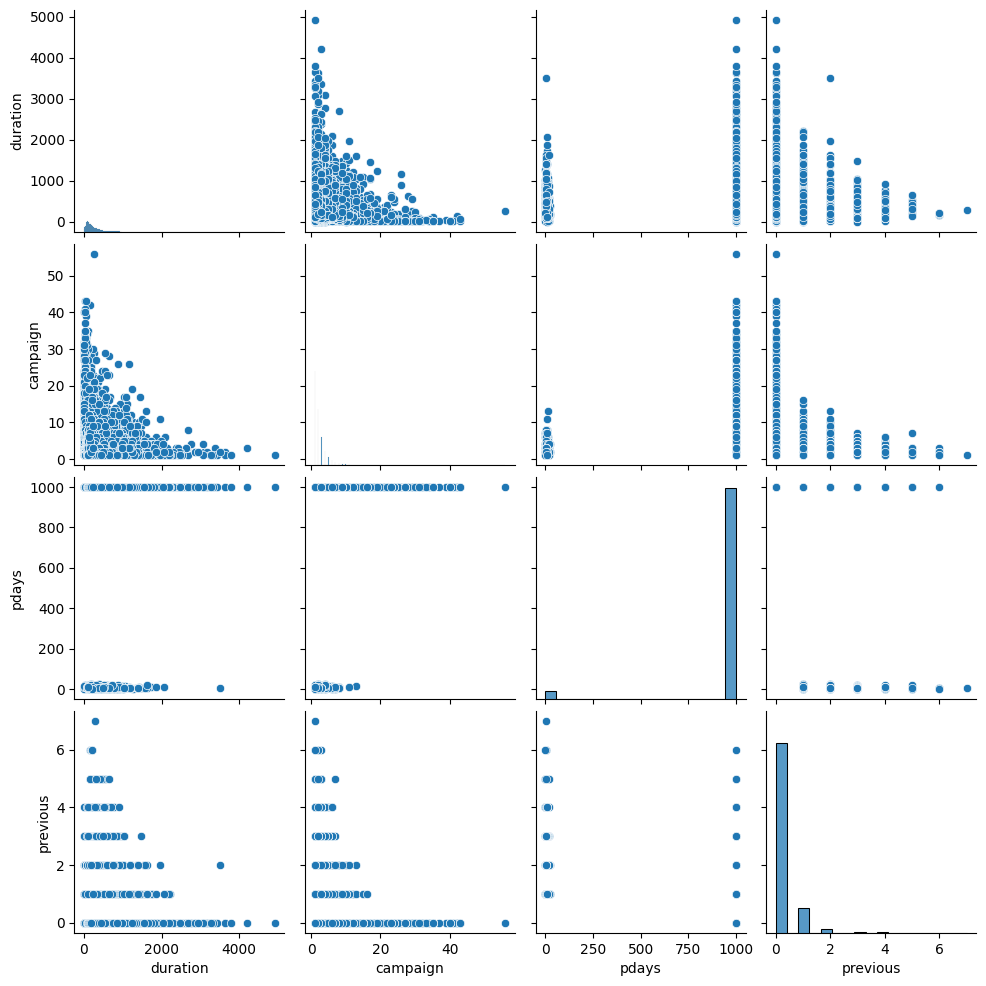

In [23]:
# Looking at the numeric data in pairplots, I see that pdays
# only really has two values so probably does not provide much information.
sns.pairplot(df.select_dtypes('number').iloc[:, 1:5])

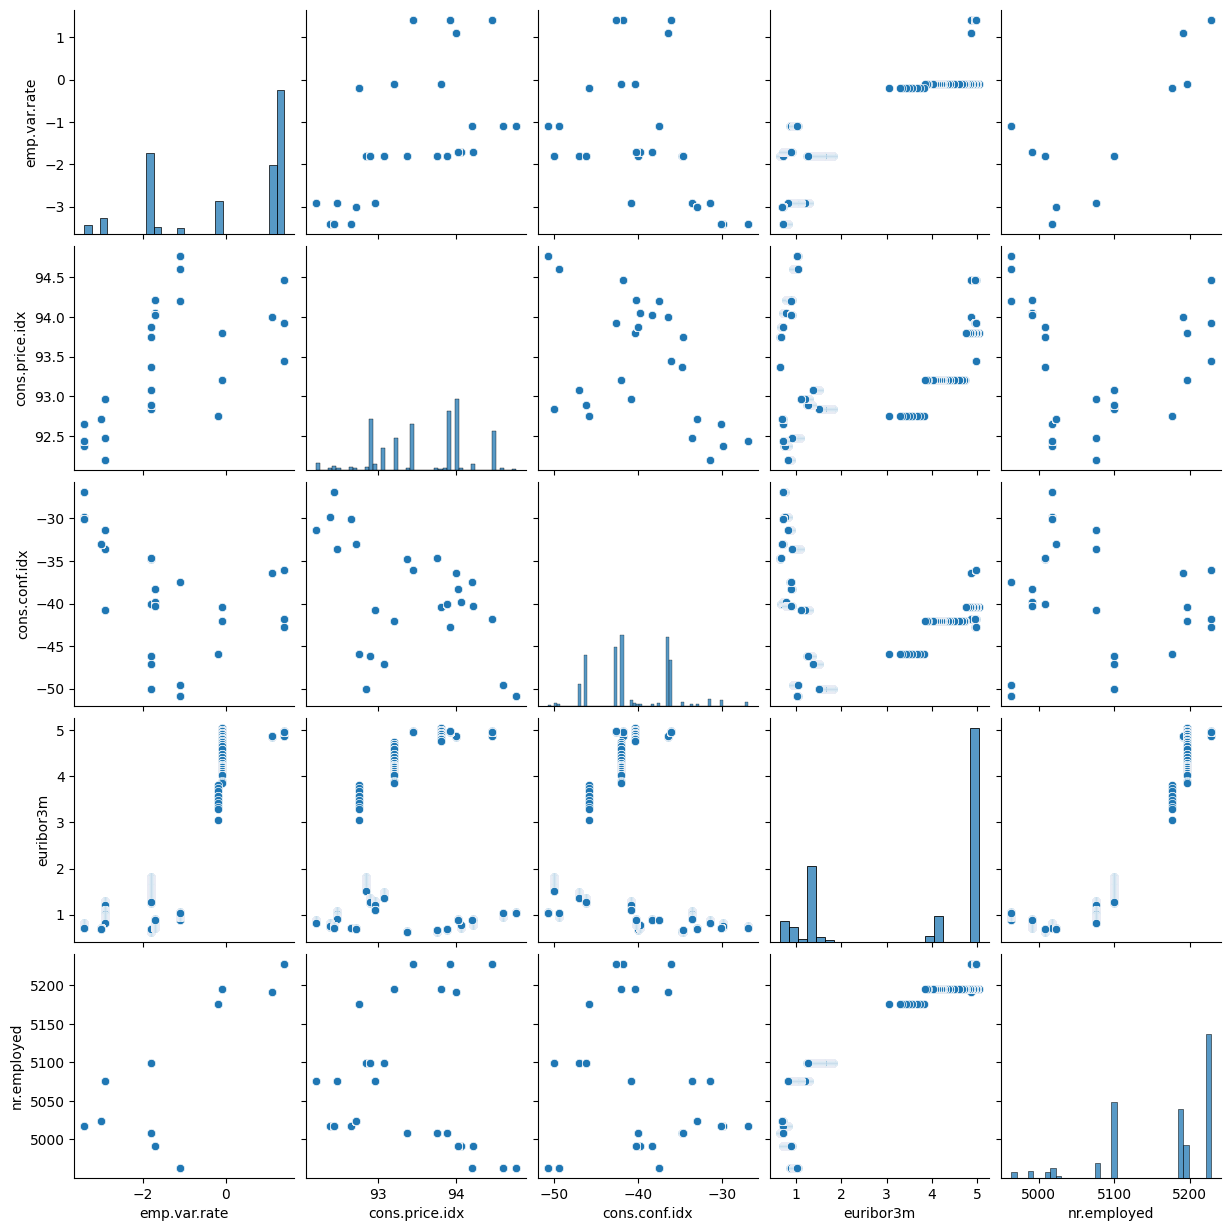

In [24]:
# The remaining numeric columns look to have greater variation
sns.pairplot(df.select_dtypes('number').iloc[:, 5:])

In [25]:
# Drop pdays due to little variation
xTrain = xTrain.drop(columns='remainder__pdays')
xTest = xTest.drop(columns='remainder__pdays')

# Map yTrain to 1 and 0 for recall scoring to work
yTrain = yTrain.map(dict(yes=1, no=0))

In [37]:
# Logistic Regression Hyperparameter Grid
logParams = {
  'penalty': ['l1','l2','elasticnet'],
  'class_weight': [None, 'balanced'],
  'solver': ['liblinear', 'lbfgs']
}

knnParams = {
  'n_neighbors': [3,5,10,20],
  'weights': ['uniform','distance'],
}

dtParams = {
  'criterion': ['gini','entropy','log_loss'],
  'max_depth': [15, 20, 25, 30]
}

# My computer keeps crashing while doing grid search on SVM,
# so I'm keeping this small
svmParams = {
  'C': [1, 10],
  'kernel': ['rbf', 'linear']
}

modelsAndParams = [
  ('Logistic', LogisticRegression(), logParams),
  ('KNN', KNeighborsClassifier(), knnParams),
  ('DT', DecisionTreeClassifier(), dtParams),
  ('SVM', SVC(), svmParams)
]

In [38]:
# Set up data frame to show final results
colNames = ['Model','Params', 'Fit Time', 'Recall']
bestModels = pd.DataFrame(columns=colNames)

# Function for creating df from model results
def dfForResult(modelName, results):
  arr = results.array
  return(pd.DataFrame([[modelName, arr[0], arr[1], arr[2]]],
           columns = colNames))

In [ ]:
for name, m, p in modelsAndParams:
  # Use recall scoring since we're looking to maximize our
  # ability to identify the positive case
  mSearch = GridSearchCV(m, p, scoring='recall', n_jobs=-1)
  
  print(f"Searching {name}...")
  mSearch.fit(xTrain, yTrain)
  
  results = pd.DataFrame(mSearch.cv_results_).query('mean_test_score.notna()').sort_values('rank_test_score')
  results = results[['params','mean_fit_time','mean_test_score']]
  bestModel = results.iloc[1,:]
  row = dfForResult(name, bestModel)
  
  bestModels = pd.concat(
    [bestModels, dfForResult(name, bestModel)], ignore_index=True)
  

In [40]:
bestModels

,Model,Params,Fit Time,Recall
0,Logistic,"{'class_weight': 'balanced', 'penalty': 'l1', ...",4.573120,0.885230
1,KNN,"{'n_neighbors': 3, 'weights': 'uniform'}",0.018376,0.312569
2,DT,"{'criterion': 'entropy', 'max_depth': 15}",0.123731,0.532311
3,SVM,"{'C': 1, 'kernel': 'rbf'}",11.554473,0.371978


<Axes: xlabel='Fit Time', ylabel='Recall'>

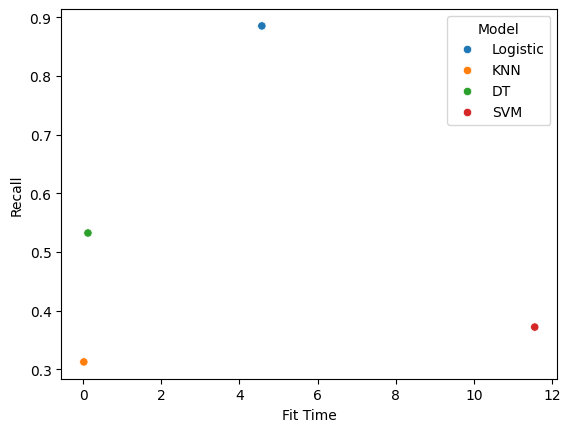

In [42]:
# With this scatter plot, we can see the Logistic model performs the best
# when scoring with recall. DT trains very quickly so potentially we should
# experiment with more hyperparameters, but otherwise I would recommend
# the logistic model with the parameters listed in the dataframe above.
sns.scatterplot(bestModels, x='Fit Time', y='Recall', hue='Model')

### Suggestions for Bank
I would suggest using this logistic classification model to prioritize calls in the call center. This should maximize their calling success (looking for the "yes" answer) and improve their operations rapidly.

Beyond that, I would analyze the coefficients in the model to identify where the bank should find more customers for their sales funnel. This will give them demographic info they can use to purchase lead lists, or access within their own CRM. This may also help them refine their pitch.